# Using Indigo for DC Removal in X-Space MPI

Based on Konkle et al. [A Convex Formulation for Magnetic Particle Imaging X-Space Reconstruction](https://doi.org/10.1371/journal.pone.0140137).

## Load example image

Populating the interactive namespace from numpy and matplotlib


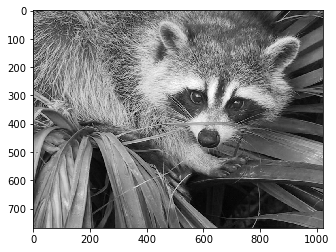

In [1]:
%pylab inline

import h5py
import logging
import argparse
import numpy as np
from scipy import misc
import scipy.sparse as spp

img = misc.face()
img = img[:,:,0] # select one color channel
img = img.astype(np.complex64) # change datatype
plt.imshow(abs(img), cmap='gray', interpolation='none')

## Generate synthetic pFOV data

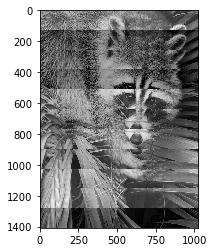

In [2]:
x,z = img.shape
p = width = 128
s = overlap = 32
g = gap = p-2*s

pfovs = np.array([img[c:c+p,:] for c in range(0,x-g,g)])

img_dc = np.mean(abs(img))
dc_offsets = (np.random.rand(len(pfovs)) - 0.5) * img_dc
pfovs += dc_offsets[:,None,None]

plt.imshow( abs(pfovs).reshape((-1,z)), cmap='gray', interpolation='nearest' )

## Construct Operators

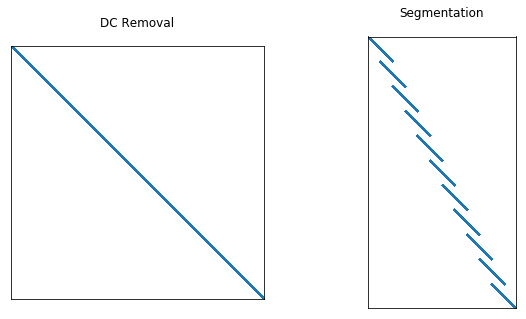

In [3]:
# construct segmentation operator
indices = np.arange(img.size).reshape(img.shape)
S_shape = (pfovs.size, img.size)
data = np.ones(pfovs.size, dtype=np.complex64)
rows = np.arange(pfovs.size)
cols = np.array([indices[c:c+p,:] for c in range(0,x-g,g)]).flatten()
SegOp = spp.coo_matrix((data, (rows,cols)), shape=S_shape)

# construct dc removal operator
DcRemOp = spp.eye( SegOp.shape[0], dtype=SegOp.dtype )
DcRemOp.data -= 1/p

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.set_title("DC Removal")
ax0.spy(DcRemOp, markersize=.01)
ax0.xaxis.set_visible(False)
ax0.yaxis.set_visible(False)

ax1.set_title("Segmentation")
ax1.spy(SegOp, markersize=.01)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

## Create Indigo Operator

In [4]:
!pip install --user indigo

# instantiate backend
import indigo.backends
from indigo.transforms import *

B = indigo.backends.get_backend('mkl') # or numpy, cuda, etc.

S = B.SpMatrix(SegOp, name='segment')
D = B.SpMatrix(DcRemOp, name='dcrem')

A = D*S
A._name = 'mpi'

## Solve via conjugate gradient

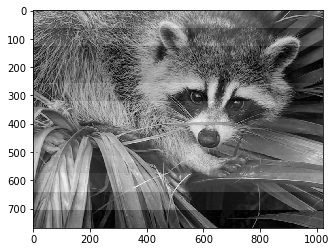

In [5]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

# cg prep
AHy = A.H * Y
AHA = (A.H * A).optimize([RealizeMatrices])

# reconstruct
B.cg(AHA, AHy, X, maxiter=1000)

img_rec = X.T.reshape(img.shape)
plt.imshow(abs(img_rec), cmap='gray', interpolation='none')

## Solve via FISTA

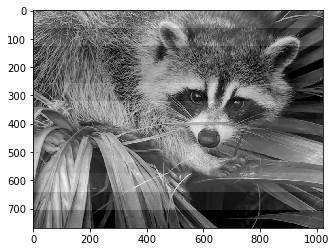

In [6]:
# reshape vectors into 2d fortran-ordered arrays
Y = pfovs.copy().reshape((1,-1)).T
X = np.zeros_like(img).reshape((1,-1)).T

AHy_d = B.copy_array(AHy)

def proxg(alpha, x_d):
    # x = max(x, 0)
    x_h = x_d.to_host()
    x_h = np.maximum(x_h, 0)
    x_d.copy_from(x_h)
    
def gradf(gf, x):
    # gf = AHA*x - AHy
    AHA.eval(gf, x)
    B.axpby(gf, -1, AHy_d)

alpha = 0.01
B.apgd(gradf, proxg, alpha, X, maxiter=1000)

img_rec = X.T.reshape(img.shape)
plt.imshow(abs(img_rec), cmap='gray', interpolation='none')